In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver13.csv")
df2 = pd.read_csv("data/26년FA_야수_ver2.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 처리 함수 정의
def preprocess(df):
    df = df.copy()

    # 조건 필터링
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    # 컬럼 제거
    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # 선수명 기준 평균 후 중복 제거
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)

    return df


# 전처리 적용
df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_22124\2315612900.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


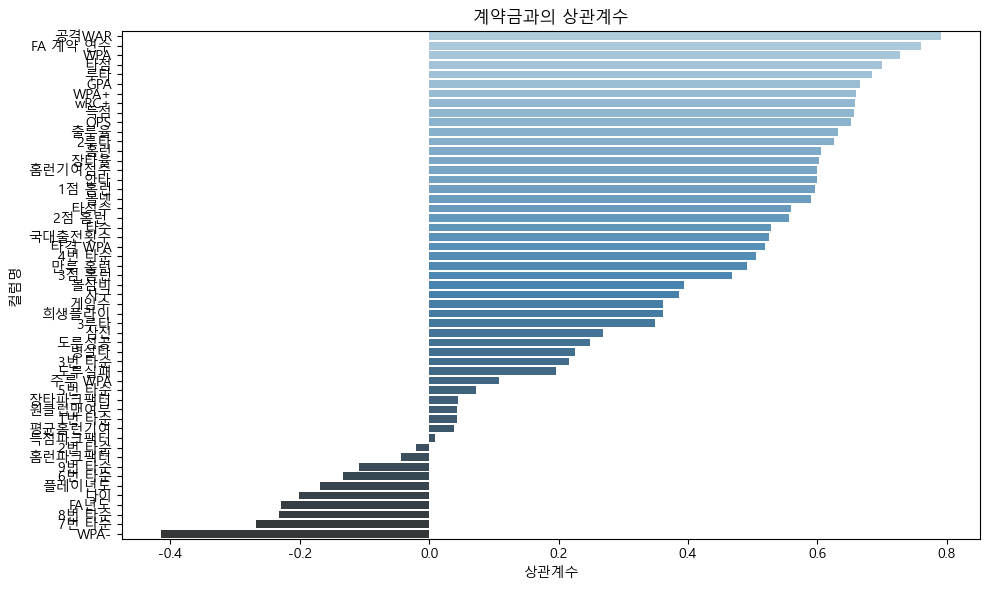

In [5]:
# 계약금과의 상관계수 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)

# 한글 시각화 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 상관계수 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [6]:
# 가중치 계산
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})
print("상관계수 기반 가중치:")
print(weight_df)

# 공통 피처 추출
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
print(f"예측에 사용될 공통 피처: {predict_features}")

상관계수 기반 가중치:
         컬럼명       가중치
0      공격WAR  0.037415
1   FA 계약 연수  0.035968
2        WPA  0.034405
3         타점  0.033115
4         루타  0.032392
5        GPA  0.031468
6       WPA+  0.031188
7       wRC+  0.031113
8         득점  0.031086
9        OPS  0.030850
10       출루율  0.029911
11       2루타  0.029629
12        홈런  0.028681
13       장타율  0.028517
14    홈런기여점수  0.028368
15        안타  0.028334
16     1점 홈런  0.028206
17        볼넷  0.027885
18       타석수  0.026472
19    2점 홈런   0.026305
20        타수  0.025004
21    국대출전횟수  0.024811
22    타격 WPA  0.024543
23     4번 타순  0.023925
24     만루 홈런  0.023244
25     3점 홈런  0.022117
26       볼삼비  0.018640
27        사구  0.018232
28       게임수  0.017121
29     희생플라이  0.017067
30       3루타  0.016514
31        삼진  0.012702
32      도루성공  0.011745
33       병살타  0.010658
34     3번 타순  0.010242
35      도루실패  0.009282
36    주루 WPA  0.005100
37     5번 타순  0.003458
38    장타파크팩터  0.002134
39    원클럽맨여부  0.002069
40     1번 타순  0.002025
41    평균홈런기여  0.00182

In [7]:
# 학습 데이터 준비
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']

# train/val 분할 및 스케일링
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(df2_cleaned[predict_features])

In [8]:
# GridSearchCV + XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, verbosity=0)
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [9]:
# 성능 확인
val_pred = best_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"[XGBoost + GridSearchCV] 검증 RMSE: {rmse:,.2f}")
print("최적 하이퍼파라미터:", grid.best_params_)

# 예측 결과 저장
df2_cleaned['계약금'] = best_model.predict(X_test_scaled)

[XGBoost + GridSearchCV] 검증 RMSE: 141,161.17
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\Lee\AppData\Local\Temp\ipykernel_22124\404220946.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='중요도 (XGBoost)', y='컬럼명', palette='PuBuGn_r')


피처 중요도 (XGBoost):
       컬럼명  중요도 (XGBoost)  상관계수 기반 가중치
3       루타       0.142580     0.032392
19  국대출전횟수       0.140798     0.024811
0    공격WAR       0.122514     0.037415
8      OPS       0.111213     0.030850
9      출루율       0.092821     0.029911
41  홈런파크팩터       0.057233     0.002038
6     wRC+       0.043102     0.031113
1      WPA       0.033538     0.034405
5     WPA+       0.024705     0.031188
34  주루 WPA       0.024111     0.005100
24     볼삼비       0.022303     0.018640
2       타점       0.020257     0.033115
10     2루타       0.018838     0.029629
23   3점 홈런       0.016710     0.022117
27   희생플라이       0.013707     0.017067
25      사구       0.010481     0.018232
44   플레이년도       0.009131     0.007939
48   7번 타순       0.007683     0.012611
32   3번 타순       0.006396     0.010242
35   5번 타순       0.005099     0.003458
38   1번 타순       0.005012     0.002025
20  타격 WPA       0.004829     0.024543
16      볼넷       0.004730     0.027885
30    도루성공       0.004671     0.011745
21   4번

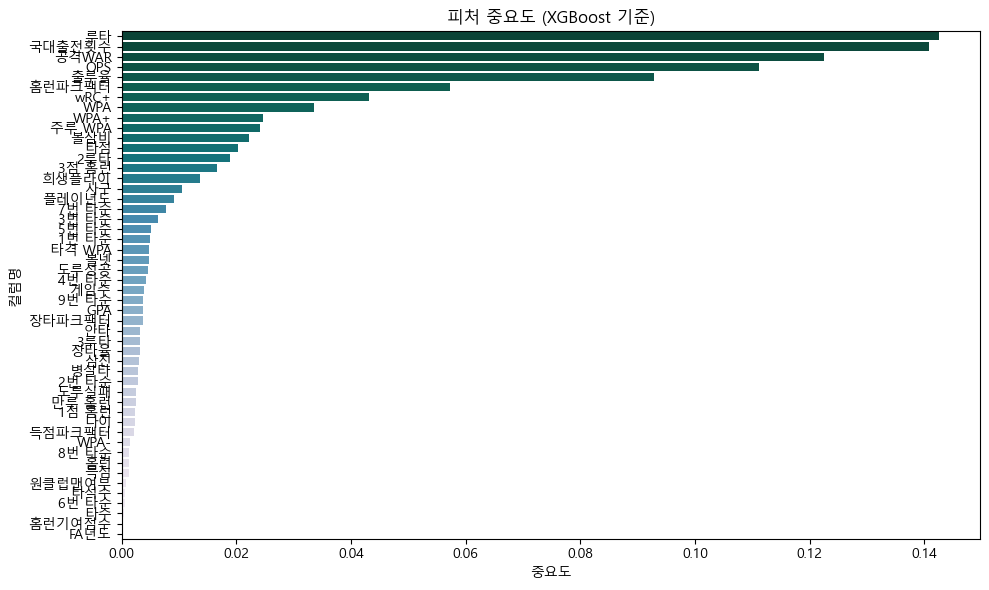

In [10]:
# 피처 중요도 출력
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (XGBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (XGBoost)', ascending=False)

print("피처 중요도 (XGBoost):")
print(importance_df)

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='중요도 (XGBoost)', y='컬럼명', palette='PuBuGn_r')
plt.title('피처 중요도 (XGBoost 기준)')
plt.xlabel('중요도')
plt.ylabel('컬럼명')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
df2_cleaned['계약금'] = df2_cleaned['계약금'].round(0).astype(int)
print("예측 계약금 상위 선수:")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수:
    선수명     계약금
0   강민호  193424
1   강백호  128509
2   김재환  181371
3   박병호  173705
4   박승욱   33230
5   박찬호  146652
6   박해민  196330
7   손아섭  132339
8   이재원   94813
9   장성우  158446
10   정훈   22847
11  조수행   30690
12  최원준  115700
13  최형우  226223
14  황재균  112747
